In [1]:
import gym
import torch
from torch import nn, optim, functional as F
import numpy as np
from IPython.display import clear_output
import pytorch_lightning as pl
import matplotlib
import matplotlib.pyplot as plt
import random
import math
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()


In [2]:
# Defining the Environment Name
env_name = 'FrozenLake-v1'
# env_name = "CartPole-v1"
# Environment Utility and Initialization class

class Environment(gym.wrappers.time_limit.TimeLimit):
    
    def __init__(self, env_name, *args, **kwargs):
        super(Environment, self).__init__(gym.make(env_name,  *args, **kwargs))
        self.print_env()
    
    def print_env(self):
        print("Environment Name: ", self.spec.name)
        print("Action Space Type: ", "DISCRETE" if type(self.action_space) == gym.spaces.discrete.Discrete else "CONTINUOUS" )
        print("Observation Space Type: ", "DISCRETE" if type(self.observation_space) == gym.spaces.discrete.Discrete else "CONTINUOUS" )
        print("Observation Space: ", self.observation_space)
        
    def __del__(self):
        self.close()

env = Environment(env_name, render_mode="rgb_array", is_slippery=False, map_name="4x4")

Environment Name:  FrozenLake
Action Space Type:  DISCRETE
Observation Space Type:  DISCRETE
Observation Space:  Discrete(16)


In [3]:
# Device Utility

device = "cpu" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print("Device : ", device)

Device :  cpu


## Replay Memory

In [4]:
from collections import namedtuple, deque

In [5]:
transition = namedtuple("Transition", ("state", "action", "next_state", "reward", "terminate"))

class ReplayMemory:
    
    def __init__(self, capacity=10000):
        self.memory = deque([], maxlen=capacity)
    
    def push(self, *args):
        self.memory.append(transition(*args))
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [6]:
class DQN(nn.Module):
    
    def __init__(self, in_features, out_features):
        super().__init__()
        self.model = nn.ModuleList(
        [
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, out_features),
        ])
    
    def forward(self, observe):
#         import pdb; pdb.set_trace()
        resp = observe
        for x in self.model:
            resp = x(resp)
        return resp

Now we have define the model and replay memory. 

Now we are going to define the Hyperparameters, objective function, selection process. 

In [7]:
LR = 0.9
N_ACTIONS = env.action_space.n
N_OBSERVATIONS = 1
EPSILON = 0.95
steps_done = 0
BATCH_SIZE = 8
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
GAMMA = 0.99

policy_net = DQN(N_OBSERVATIONS, N_ACTIONS).to(device)
target_net = DQN(N_OBSERVATIONS, N_ACTIONS).to(device)
target_net.load_state_dict(policy_net.state_dict())


optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

# Memory initialization
replay_buffer = ReplayMemory(capacity = 100000)

In [8]:
def select_action(state):
    global steps_done
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * (steps_done / EPS_DECAY))
    steps_done +=1
    if random.random() < eps_threshold:
        return torch.tensor(env.action_space.sample())
    else:
        with torch.no_grad():
            return policy_net(torch.tensor([state], dtype=torch.float32)).argmax()

    

episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [9]:
replay_buffer = ReplayMemory(10000)

In [10]:
def train_model():
    """
    For model training 
    1. Check if memory have enough records to be fetched.
    2. Fetch the records from memory
    3. Preprocess the records. 
    4. Model execution
    5. loss optimization 
    6. optimizer steps
    
    """
    # Checking for the records
    if len(replay_buffer) < BATCH_SIZE:
        return None
    
    # Fetching records
    batch_data = replay_buffer.sample(BATCH_SIZE)
    
    # Converting row batch to column batch
    batches = transition(*zip(*batch_data))
    
    # Non-Terminated States
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batches.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.tensor([x for x in batches.next_state if x is not None], device=device, dtype=torch.float32).view(-1, 1)
    
    # Preprocess records
    states = torch.tensor(batches.state).view(-1, 1).to(device)
    actions = torch.tensor(batches.action).view(-1, 1).to(device)
    rewards = torch.tensor(batches.reward).view(-1, 1).to(device)

    # Train Execution
    pred_actions = policy_net(states).gather(1, actions)
    
    
    next_state_batch = torch.zeros((BATCH_SIZE)).to(device)
    with torch.no_grad():
        next_state_batch[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    expected_state_action_values = (next_state_batch * GAMMA) + rewards

    
    # Define Criteria 
    criteria = nn.SmoothL1Loss()
    loss = criteria(pred_actions, expected_state_action_values)
    
    # Optimization 
    optimizer.zero_grad()
    loss.backward()
    
    # Gradient Clipping
    nn.utils.clip_grad_norm(policy_net.parameters(), 100)
    optimizer.step()
    

# Start the episodes to execute the model and optimize the model

In [11]:
N_EPOCHS = 1000

Completed


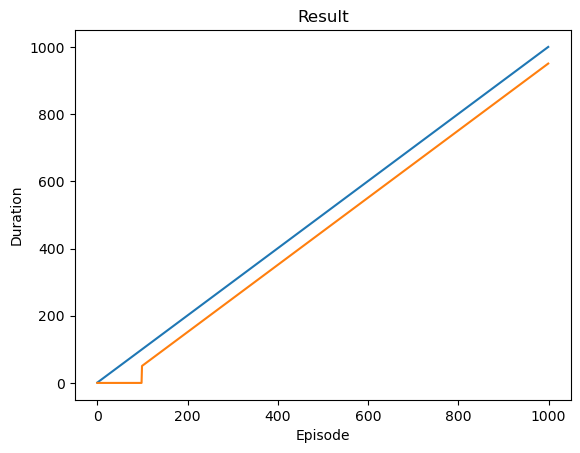

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [12]:
for epoch in range(N_EPOCHS):
    state, info = env.reset()
    done = False
    while not done:
        
        # Get the actions 
        action = select_action(state)
        
        next_state, reward, terminate, truncate, *_ = env.step(action.item())
        done = truncate or terminate
        
        # Next State None if terminated
        next_state = None if terminate else torch.tensor(next_state, dtype=torch.float32)
        if terminate and reward == 0:
            reward = -1
        
        # Pushing transition to replay_buffer
        replay_buffer.push(state, action, next_state, reward, terminate)
        state = next_state
        
        # Model training
        train_model()

        # Updating weights for target net 
        policy_net_state_dict = policy_net.state_dict()
        target_net_state_dict = target_net.state_dict()
        
        for key, val in policy_net_state_dict.items():
            target_net_state_dict[key] = val * TAU + target_net_state_dict[key] * (1-TAU)
        
        target_net.load_state_dict(target_net_state_dict)
        
        # Plot the losses
        if done:
            episode_durations.append(epoch + 1)
            plot_durations()

print("Completed")
plot_durations(True)
plt.ioff()
plt.show()

In [ ]:
for i in range(10):
    state, _ = env.reset()
    done = False
    state = torch.tensor(state, dtype=torch.float32)
    while not done:
        # Get the actions 
        action = select_action(state)
        
        next_state, reward, terminate, truncate, *_ = env.step(action.item())
        done = truncate or terminate
        next_state = None if terminate else torch.tensor(next_state, dtype=torch.float32)
        reward = torch.tensor(reward, dtype=torch.float32)
#         replay_buffer.push(state, action, next_state, reward, terminate)
        state = next_state
        